In [2]:
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict, IterableDatasetDict
from datasets.iterable_dataset import IterableDataset

dataset: DatasetDict | Dataset | IterableDatasetDict | IterableDataset = load_dataset("ealvaradob/phishing-dataset", "combined_reduced", trust_remote_code=True, split="train")

if not isinstance(dataset, Dataset):
    raise ValueError("Expected a Dataset object")


In [3]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 77677
})

In [4]:
print(dataset[5])

{'text': 'Sex up ur mobile with a FREE sexy pic of Jordan! Just text BABE to 88600. Then every wk get a sexy celeb! PocketBabe.co.uk 4 more pics. 16 £3/wk 087016248', 'label': 1}


In [5]:
from datasets import Dataset
from sklearn.model_selection import train_test_split

df = dataset.to_pandas()
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, test = Dataset.from_pandas(train, preserve_index=False), Dataset.from_pandas(test, preserve_index=False)


In [14]:
print(train.shape)
print(test.shape)

# This is too much data, I will only use a subset of it

test= test.select(range(4046))
print(test.shape)

(62141, 2)
(15536, 2)
(4046, 2)


In [ ]:
from pydantic import BaseModel
from llm import LLM, LLMName
from conversations import Conversation
from phishing import PhishingEvaluation, evaluate_phishing

llm = LLM(LLMName.LLAMA_3_1_8B_FINETUNED)

class Evaluation(BaseModel):
    is_correct: bool
    text: str
    is_phishing: bool
    phishing_evaluation: PhishingEvaluation


# label 0 is non-phishing, label 1 is phishing
evaluations: list[Evaluation] = []
correct_evaluations = 0
wrong_evaluations = 0

for idx, row in enumerate(test):
    text = row['text']
    label = row['label']
    evaluation = evaluate_phishing(llm, text)
    # print(f"{idx}: {'Phishing' if label == 1 else 'Non-phishing'} - {text}")
    evaluations.append(
        Evaluation(
            is_correct=evaluation.is_phishing == (label == 1),
            text=text,
            is_phishing=label,
            phishing_evaluation=evaluation
        )
    )
    if evaluation.is_phishing == (label == 1):
        correct_evaluations += 1
    else:
        wrong_evaluations += 1
    print(f"{idx}: Model classified as {'phishing' if evaluation.is_phishing else 'Non-phishing'} when it is {'phishing' if label == 1 else 'Non-phishing'}")

    # if idx > 10:
    #     break

print(f"Correct evaluations: {correct_evaluations}")
print(f"Wrong evaluations: {wrong_evaluations}")
print(f"Accuracy: {correct_evaluations / len(evaluations)}")
print(f"Total evaluations: {len(evaluations)}")
    

0: Model classified as Non-phishing when it is Non-phishing
1: Model classified as phishing when it is phishing
2: Model classified as Non-phishing when it is Non-phishing
3: Model classified as Non-phishing when it is Non-phishing
4: Model classified as Non-phishing when it is phishing
5: Model classified as phishing when it is phishing
6: Model classified as Non-phishing when it is Non-phishing
7: Model classified as phishing when it is phishing
8: Model classified as phishing when it is phishing
9: Model classified as Non-phishing when it is Non-phishing
10: Model classified as Non-phishing when it is phishing
11: Model classified as Non-phishing when it is Non-phishing
12: Model classified as phishing when it is phishing
13: Model classified as Non-phishing when it is Non-phishing
14: Model classified as Non-phishing when it is phishing
15: Model classified as Non-phishing when it is Non-phishing
16: Model classified as phishing when it is phishing
17: Model classified as Non-phish

KeyboardInterrupt: 

In [ ]:
import pickle

with open('evaluations-llama-3.1-8B-finetuned.pkl', 'wb') as f:
    pickle.dump(evaluations, f)

In [11]:
print(len(evaluations))

4046


{'False': {'precision': 0.8284095507891542, 'recall': 0.8710638297872341, 'f1-score': 0.8492014104957478, 'support': 2350.0}, 'True': {'precision': 0.8076190476190476, 'recall': 0.75, 'f1-score': 0.7777438092326505, 'support': 1696.0}, 'accuracy': 0.8203163618388531, 'macro avg': {'precision': 0.8180142992041008, 'recall': 0.810531914893617, 'f1-score': 0.8134726098641991, 'support': 4046.0}, 'weighted avg': {'precision': 0.8196945993861634, 'recall': 0.8203163618388531, 'f1-score': 0.8192478534660363, 'support': 4046.0}}


/tmp/ipykernel_256043/2912224618.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Phishing', 'Non-Phishing'], y=[phishing_count, non_phishing_count], palette='viridis')


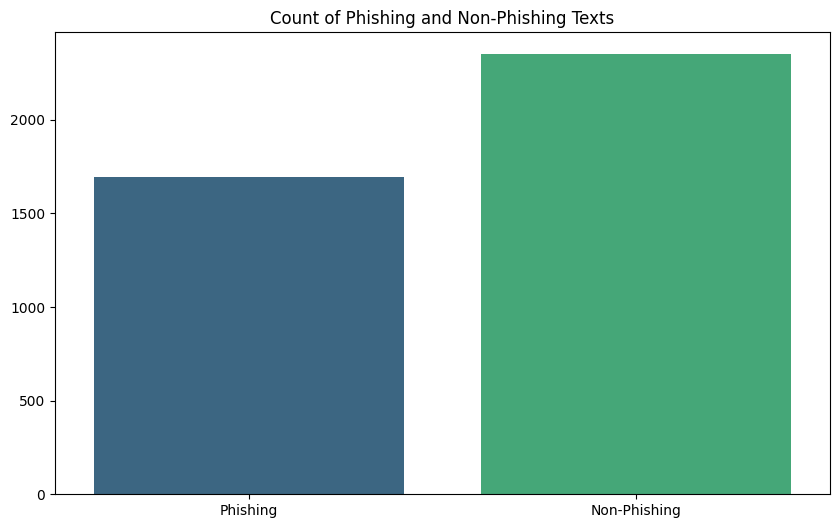

/tmp/ipykernel_256043/2912224618.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Classified as Phishing', 'Classified as Non-Phishing'], y=[classified_phishing_count, classified_non_phishing_count], palette='viridis')


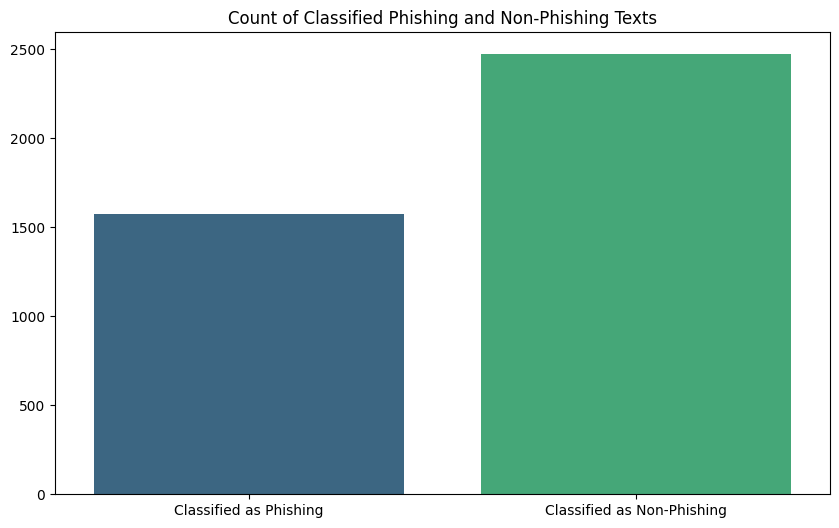

/tmp/ipykernel_256043/2912224618.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Correct Classifications', 'Incorrect Classifications'], y=[correct_classifications, incorrect_classifications], palette='viridis')


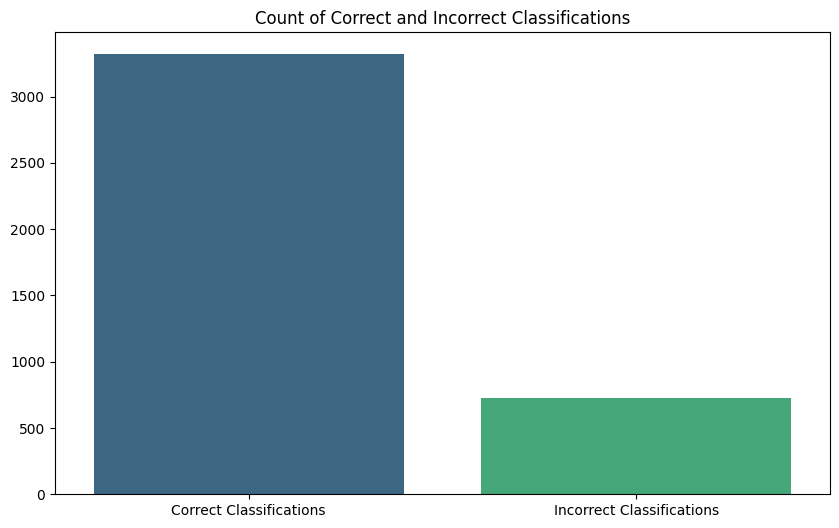

Confusion Matrix:
[[2047  303]
 [ 424 1272]]
Classification Report:
              precision    recall  f1-score   support

       False       0.83      0.87      0.85      2350
        True       0.81      0.75      0.78      1696

    accuracy                           0.82      4046
   macro avg       0.82      0.81      0.81      4046
weighted avg       0.82      0.82      0.82      4046

False Positive Rate: 0.8076190476190476
False Negative Rate: 0.8710638297872341
Precision: 0.8076190476190476
Recall: 0.75
F1 Score: 0.7777438092326505
Correctly Classified Examples:
                                                text  is_phishing  \
0  http://www.rokuki.com/family-of-discovery-go-c...        False   
1  ademas.sn/wp-admin/box/box/index2.php?JNhFQlwP...         True   
2  <!doctypehtml><html class="no-js no-svg"lang=e...        False   
3        http://dictionary.babylon-software.com/dna/        False   
5  fancy a flutter ? here 's a tip ! ! = 20 we ti...         True   

   pred

In [21]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# Convert evaluations to a DataFrame
eval_df = pd.DataFrame([{
    'text': eval.text,
    'is_phishing': eval.is_phishing,
    'predicted_phishing': eval.phishing_evaluation.is_phishing,
    'confidence': eval.phishing_evaluation.confidence,
    'is_correct': eval.is_correct
} for eval in evaluations])

# Count phishing and non-phishing texts
phishing_count = eval_df['is_phishing'].sum()
non_phishing_count = len(eval_df) - phishing_count

# Count texts classified as phishing and non-phishing
classified_phishing_count = eval_df['predicted_phishing'].sum()
classified_non_phishing_count = len(eval_df) - classified_phishing_count

# Count correct and incorrect classifications
correct_classifications = eval_df['is_correct'].sum()
incorrect_classifications = len(eval_df) - correct_classifications

# Create a confusion matrix
conf_matrix = confusion_matrix(eval_df['is_phishing'], eval_df['predicted_phishing'])

# Calculate false positive rate, false negative rate, precision, recall, f1 score
report = classification_report(eval_df['is_phishing'], eval_df['predicted_phishing'], output_dict=True)
print(report)
false_positive_rate = report['True']['precision']
false_negative_rate = report['False']['recall']
precision = report['True']['precision']
recall = report['True']['recall']
f1_score = report['True']['f1-score']

# Show some examples of texts that are classified correctly and incorrectly
correct_examples = eval_df[eval_df['is_correct']].head(5)
incorrect_examples = eval_df[~eval_df['is_correct']].head(5)

# Show it in a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=['Phishing', 'Non-Phishing'], y=[phishing_count, non_phishing_count], palette='viridis')
plt.title('Count of Phishing and Non-Phishing Texts')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=['Classified as Phishing', 'Classified as Non-Phishing'], y=[classified_phishing_count, classified_non_phishing_count], palette='viridis')
plt.title('Count of Classified Phishing and Non-Phishing Texts')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=['Correct Classifications', 'Incorrect Classifications'], y=[correct_classifications, incorrect_classifications], palette='viridis')
plt.title('Count of Correct and Incorrect Classifications')
plt.show()

print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(eval_df['is_phishing'], eval_df['predicted_phishing']))

print("False Positive Rate:", false_positive_rate)
print("False Negative Rate:", false_negative_rate)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

print("Correctly Classified Examples:")
print(correct_examples)

print("Incorrectly Classified Examples:")
print(incorrect_examples)